In [1]:
import torch
import torch.nn as nn

## Loading data

In order to load data from rasters into python, we need to use the `rasterio` module. Below is an example of how to open and visualize a file using rasterio.

### Finding files

Before we can load files, we need to know where they are at. In this case, there is some NAIP data that has aleady been sampled stored in `./data` with the following directory structure:

```
| data/
|| NAIP_PATCH_ID/ 
||| input/
|||| 00000.tif (sample from corresponding patch)
|||| 00001.tif
|||| 00002.tif
|||| ...
||| target/
|||| 00000.tif (sampl from corresponding patch's ground truth data)
|||| 00001.tif
|||| 00002.tif
|||| ...
```

Knowing this, we can write a function that aggregates the NAIP data and their corresponding ground truth labels into a list of 2-tuples.

In [2]:
import os
def get_list_of_files(data_path: str='./data') -> list[tuple[str, str]]:
    '''Returns a list of tuples of the form (path_to_input_sample, path_to_label)
    
    Parameters:
    data_path (str): path to the root of the data directory
    
    Returns:
    list[tuple[str, str]]: List of file paths with corresponding ground truth labels
    '''
    
    # get list of patch ids. list comprehension pretty much says "look at the 
    # items in the data_path directory and if they are directories, add them to 
    # the list"
    file_paths = []
    patch_ids = [sub_dir for sub_dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub_dir))]
    
    for patch in patch_ids:
        # get all subsamples of each patch
        subsamples = os.listdir(os.path.join(data_path, patch, 'input'))
        # add subsamples to file_path list
        file_paths.extend(
            (
                os.path.join(data_path, patch, 'input', subsample),
                os.path.join(data_path, patch, 'target', subsample)
            ) for subsample in subsamples
        )
        
    
    # check to make sure files exist
    for file_path in file_paths:
        if not os.path.isfile(file_path[0]):
            raise FileNotFoundError(f'Input file {file_path[0]} not found')
        if not os.path.isfile(file_path[1]):
            raise FileNotFoundError(f'Label file {file_path[1]} not found')
    
    return file_paths
    
    
file_paths = get_list_of_files('./data')
print(f'Found {len(file_paths)} files') # always a good idea to print out the number of files found
print(file_paths[0]) # take a look at the first file path input/target 2-tuple

Found 2464 files
('./data/m_3607632_ne_18_1/input/00397.tif', './data/m_3607632_ne_18_1/target/00397.tif')


raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 224, 'height': 224, 'count': 4, 'crs': CRS.from_epsg(26918), 'transform': Affine(1.0, 0.0, 339223.0,
       0.0, -1.0, 4049128.0)}
raster shape: (4, 224, 224)
red band raster shape: (224, 224)


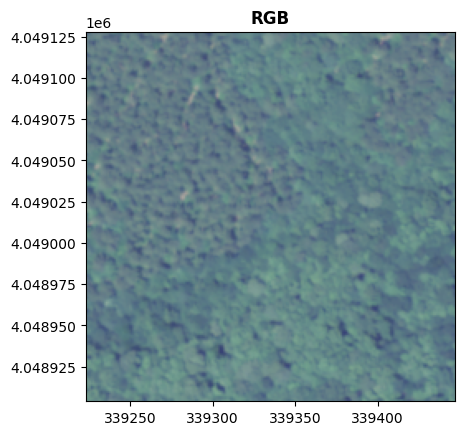

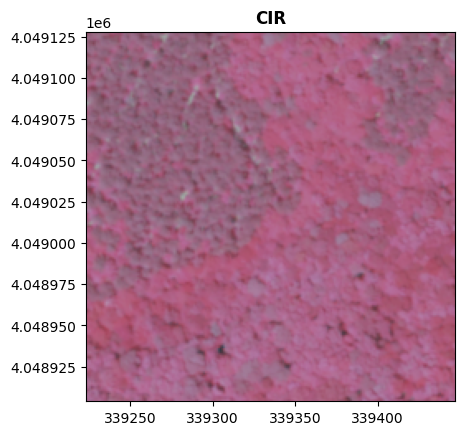

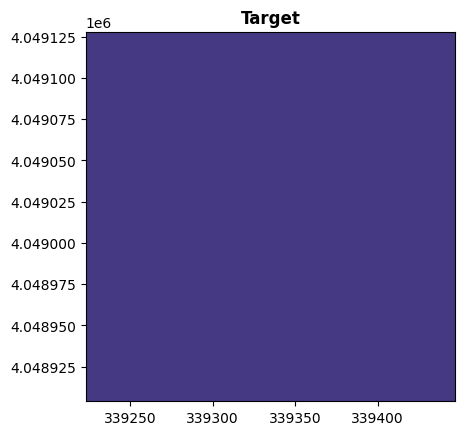

<Axes: title={'center': 'Target'}>

In [3]:
import rasterio
import numpy as np
from rasterio.plot import show

src_file = './data/m_3607626_ne_18_1/input/00098.tif'
with rasterio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data (as numpy array)
    red_band = src.read(1) # only grab red band (as numpy array)
    
print('raster metadata:', meta)
print('raster shape:', data.shape)
print('red band raster shape:', red_band.shape)

data_rgb = data[:3]
show(data_rgb, transform=meta['transform'], vmin=0, vmax=255, title='RGB')
data_cir = data[[3, 0, 1], :, :] # grab only the G R NIR bands
show(data_cir, transform=meta['transform'], vmin=0, vmax=255, title='CIR')

src_file = './data/m_3607626_ne_18_1/target/00098.tif'
with rasterio.open(src_file) as src:
    target_meta = src.meta # grab geo metadata
    target = src.read() # grab raster data (as numpy array)
    # red_band = src.read(1) # only grab red band (as numpy array)
    
show(target, transform=target_meta['transform'], vmin=1, vmax=7, title='Target')

### Housecleaning - Data Augmentation using Image Transformations

Before we write the code used for loading data to 

### Creating a Dataset class

In order to load data to train a neural network model in PyTorch, we need to create a custom class that tells PyTorch *how* to load each sample into memory, and what transformations need to be performed on each sample. If you're unfamiliar with this practice, you may not immediately see the value in it compared to simply using a list of samples or `numpy` arrays. Indeed, it may seem like more unnecessary boiler-plate code, but there are several important reasons why creating a custom `torch.utils.data.Dataset` class has its advantages:

1. Subclassing `Dataset` gives us near complete control on how data is loaded and passed to the model. For small, simple datasets it often more than enough to use a `numpy` array to load samples for training. However, when working with large, complicated datasets, we often need to load samples directly from the disk on the fly and transform them to be suitable for training. Using the `__getitem__` method gives us near-unlimited options with regards to the type of data we need to load, how that data is stored (memory, disk, network, etc.), and any transforms/pre-processing that needs to be performed on the data.

2. Using the `Dataset` class allows us to unlock the powerful features of object-oriented programming. We can store important information about the dataset - such as the distribution of classes, means, standard deviations, metadata, and more and access them easily, from both within the `Dataset` class definition and the object itself. As such, your dataset can have all sorts of useful properties outside of just the data. In the following example, we can have the `__getitem__` method of our `Dataset` class return the metadata of the sample - allowing us to easily save rasters with geospatial information on-the-fly during inference - but we'll save that for another day.

In the following example, we will subclass `Dataset` to create a new `NAIP_Dataset` class with options specific to 

In [82]:
from torch.utils.data import Dataset

# our custom NAIP_Dataset class will inherit from the Dataset class
class NAIP_Dataset(Dataset):
    
    def __init__(self, files: list[tuple[str, str]], transform=None):
        self.file_path_list = files
        self.transform = transform
        self.class_dist = None # we will use this later
        
    def __len__(self):
        return len(self.files)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    # In our case, we will return a tuple of the form (X, y, meta), whera meta
    # is the metadata associated with the raster file.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index] # get file path to laod
        
        # load raster data to memory
        X = rasterio.open(file_path[0]).read()
        y = rasterio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        y = y - 1
        
        # image transformations (more on this later)
        if self.transform:
            X, y = self.transform(X, y)
        
        return X, y
    
    # NOTE: we can add additional methods to our custom dataset class to make our
    # lives easier. For example, let's create a method that returns the class distribution
    # of the dataset
    
    def get_class_distribution(self) -> np.array:
        
        if self.class_dist is not None: return self.class_dist # return cached result if available
        
        # load all labels into memory (as numpy array)
        labels = np.array([rasterio.open(file_path[1]).read() for file_path in self.file_path_list])
        
        # subtract 1 from labels so that classes are indexed from 0 to 6 (instead of 1 to 7)
        labels = labels - 1
        
        # get class distribution using numpy histogram function
        self.class_dist = np.histogram(labels, bins=6)
        
        return self.class_dist

### Creating train/test/val splits

When training a deep learning model, we need at least 2 different dataset splits: a training split which consists of samples the models will train with, and a holdout set with samples that the model will not use during training. Additionally, it is also a good idea to create a validation set that is similar in size to the test split that will be used after each epoch is training is completed to determine how well the model can generalize to unseen data. If the loss calculated on the validation set is significantly greater than that of the training dataset, then our model is *overfitting*. Backpropogagtion is *not* performed on the validation or test splits meaning they have no impact on the parameters or performance of the model - these splits exist purely for evaluation purposes. 

In this example, we are simply going to randomly choose samples to go in each split. Typically 20% of the dataset is placed in the test and validation splits, wheras the remaining 60% is placed in the validation split.

In [76]:
import random

n_total_samples = len(file_paths)
n_test_samples = int(n_total_samples * 0.2) # 20% of data will be used for testing
n_val_samples = int(n_total_samples * 0.2) # 20% of data will be used for validation
n_train_samples = n_total_samples - n_test_samples - n_val_samples # the rest of the data will be used for training

print(f'Total samples: {n_total_samples}')
print(f'Train samples: {n_train_samples}')
print(f'Validation samples: {n_val_samples}')
print(f'Test samples: {n_test_samples}')

# shuffle the file paths (in-place operation)
random.shuffle(file_paths)

train_file_paths = file_paths[:n_train_samples]
val_file_paths = file_paths[n_train_samples:n_train_samples+n_val_samples]
test_file_paths = file_paths[n_train_samples+n_val_samples:]

Total samples: 2464
Train samples: 1480
Validation samples: 492
Test samples: 492



#### Image Transforms (Rotate and Flip)

When training a deep learning model for image tasks we need to use as many training samples as possible. One widely-used method for artificially boosting the number of training samples seen by a model during training is data augmentation. Under data augmentation, we randomly apply a series of image transformations to each sample of training data before being passed to the model during the training phase. Some examples of popular augmentation techniques include

* Resizing
* Cropping
* Contrast adjustment
* Color adjustment
* Pixel jitter (shift the value of each pixel slightly)
* Rotation
* Flip (vertical and horizontal).

By augmenting data before training, we try to ensure that the model does not overfit on the dataset. When the model is overfit, the model captures features in the training data too well, leading to poor generalization on other data - significantly reducing the 

In [6]:
from torchvision.transforms.functional import rotate, hflip, vflip

class RotateAndFlipTransforms:
    
    def __init__(self) -> None:
        self.angles = [90, 180, 270] # possible angles to rotate (0 and 360 are the same as the original)
        p_rotate = 0.75
        p_flip = 0.5
    
    def __call__(self, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        # rotate with probability p_rotate
        if random.random() < p_rotate: 
            angle = random.choice(self.angles) # if rotating, choose a random angle
            X = rotate(X, angle)
            y = rotate(y, angle)

        # horizontal flip with probability p_flip
        if random.random() < p_flip: # horizontal flip with probability p_flip
            X = hflip(X)
            y = hflip(y)
            
        # vertical flip with probability p_flip
        if random.random() < p_flip:
            X = vflip(X)
            y = vflip(y)
        
        return X, y

### Putting it all together

Now that we have the `NAIP_Dataset` class defined, we can put everything together and create three datasets: a test, val, and train dataset. First, we need to create a `RotateAndFlipTransforms` object, then simply create three new `NAIP_Dataset` objects.

In [83]:
train_dataset = NAIP_Dataset(train_file_paths, transform=RotateAndFlipTransforms())
class_dist = train_dataset.get_class_distribution()
print(class_dist)

(array([ 7508622, 43334591, 21562673,    54413,  1161536,   638645]), array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
       4.16666667, 5.        ]))


In [8]:
import torchvision
resnet = torchvision.models.resnet50(weights=False)

import segmentation_models_pytorch as smp

smp_unet = smp.Unet(
    in_channels=4, # input channels
    classes=1, # output channels
    encoder_name='resnet18', # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet', # use `imagenet` pretrained weights for encoder initialization
)


/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(smp_unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [71]:
# code is modified from https://github.com/milesial/Pytorch-UNet
# in order to comply with GPLv3, link to original code is provided above and 
# GPL v3 license is included in the repository

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels): # remove bilinear option
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        # CHANGE: remove the bilinear option
        # if bilinear:
        #     self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #     self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        # else:
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        print(f'UP FORWARD CALL: x1: {x1.shape}, x2: {x2.shape}')
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
        # return self.conv(x)
        
# CHANGE: final "up" layer is different from the rest of the "up" layers due to
# size mismatch between the output of the first "down" layer (64) and the 
# output of the previous "up" layer
class FinalUp(nn.Module):
    """Upscaling then double conv (Upscaling output and DoubleCov input channels mismatch)"""

    def __init__(self, in_channels, middle_channels, out_channels, bilinear=True): # remove bilinear option
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        # CHANGE: remove the bilinear option
        # if bilinear:
        #     self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #     self.conv = DoubleConv(middle_channels, out_channels, in_channels // 2)
        # else:
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(middle_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
        # return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    # CHANGE: resnet parameter is added to the constructor
    def __init__(self, n_channels, n_classes, resnet=torchvision.models.resnet18(weights=True)): # remove bilinear option
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        # self.bilinear = bilinear # remove bilinear option

        first_output_channels = resnet.conv1.out_channels
        # CHANGE: we are using resnet as our encoder. self.down attributes correspond
        # to the resnet layers. Instead of using double covolutions, we will use single conv instead
        self.inc = (DoubleConv(n_channels, first_output_channels))
        self.down1 = resnet.layer1
        self.down2 = resnet.layer2
        self.down3 = resnet.layer3
        # factor = 2 if bilinear else 1 # remove factor from the constructor
        self.down4 = resnet.layer4
        
        # CHANGE: add self.encoder to easily access the encoder layers via iteration
        self.encoder = nn.Sequential(
            self.inc,
            self.down1,
            self.down2,
            self.down3,
            self.down4
        )
        
        # CHANGE: automatically adjust the number of channels in each layer of the decoder
        # original:
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        # self.up2 = (Up(512, 256 // factor, bilinear))
        # self.up3 = (Up(256, 128 // factor, bilinear))
        # self.up4 = (Up(128, 64, bilinear))
        # self.outc = (OutConv(64, n_classes))
        
        channels = self.get_encoder_output_channels() # get the number of channels in each layer of the encoder
        self.encoder_output_channels = channels
        channels.reverse() # reverse the list of channels to start from the bottom of the decoder
        
        self.up1 = (Up(channels[0], channels[1]))
        self.up2 = (Up(channels[1], channels[2]))
        self.up3 = (Up(channels[2], channels[3]))
        self.up4 = (FinalUp(channels[3], (channels[3] // 2) + first_output_channels, channels[4]))
        self.outc = (OutConv(channels[4], n_classes))

    # CHANGE: helper function to get the number of channels in each layer of the encoder
    def get_encoder_output_channels(self):
        x = torch.randn(1, self.n_channels, 256, 256)
        
        encoder_channels = []
        for layer in self.encoder:
            x = layer(x)
            encoder_channels.append(x.shape[1])
        
        return encoder_channels
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        return logits
    
    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        
resnet = torchvision.models.resnet50(weights=True)
model = UNet(
    n_channels=4, 
    n_classes=6, 
    resnet=resnet
)
print(model.encoder_output_channels)
x = torch.randn(1, 4, 256, 256)
y = model(x)

# X_test = torch.randn(1, 4, 256, 256)
# y_hat = model.encoder(X_test)


/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[2048, 1024, 512, 256, 64]
UP FORWARD CALL: x1: torch.Size([1, 2048, 32, 32]), x2: torch.Size([1, 1024, 64, 64])
UP FORWARD CALL OUT SIZE (pre-conv) torch.Size([1, 2048, 64, 64])
UP FORWARD CALL OUT SIZE (post-conv) torch.Size([1, 1024, 64, 64])
UP FORWARD CALL: x1: torch.Size([1, 1024, 64, 64]), x2: torch.Size([1, 512, 128, 128])
UP FORWARD CALL OUT SIZE (pre-conv) torch.Size([1, 1024, 128, 128])
UP FORWARD CALL OUT SIZE (post-conv) torch.Size([1, 512, 128, 128])
UP FORWARD CALL: x1: torch.Size([1, 512, 128, 128]), x2: torch.Size([1, 256, 256, 256])
UP FORWARD CALL OUT SIZE (pre-conv) torch.Size([1, 512, 256, 256])
UP FORWARD CALL OUT SIZE (post-conv) torch.Size([1, 256, 256, 256])
FINAL UP FORWARD CALL: x1: torch.Size([1, 256, 256, 256]), x2: torch.Size([1, 64, 256, 256])
FINAL UP FORWARD CALL OUT SIZE (pre-conv) torch.Size([1, 192, 256, 256])
FINAL UP FORWARD CALL OUT SIZE (post-conv) torch.Size([1, 64, 256, 256])


In [73]:
print(y.shape)

torch.Size([1, 6, 256, 256])
tensor([[[[ 0.2674,  0.5315,  0.4722,  ...,  0.1467,  0.3573,  0.3270],
          [ 0.1053,  0.3982,  0.2515,  ..., -0.5501,  0.1417,  0.0901],
          [ 0.5435,  0.3454,  0.1408,  ...,  0.1402,  0.5701,  0.3066],
          ...,
          [ 0.1148,  0.3233,  0.1586,  ...,  0.7029,  0.3921,  0.4483],
          [ 0.5874,  0.1470,  0.3400,  ...,  0.3850,  0.0580,  0.3396],
          [ 0.1352,  0.4110, -0.0780,  ..., -0.0373,  0.2417,  0.0690]],

         [[-0.1179,  0.0903, -0.2527,  ..., -0.1285, -0.4139, -0.3513],
          [-0.5459, -0.0317, -0.3860,  ..., -0.4312, -0.1296, -0.2460],
          [-0.3886, -0.1562, -0.0027,  ...,  0.3765, -0.1820, -0.1036],
          ...,
          [-0.2448,  0.1814, -0.2315,  ..., -0.2808, -0.0501, -0.1110],
          [-0.1184, -0.0788, -0.1838,  ..., -0.3569,  0.1030,  0.2179],
          [ 0.0920, -0.1539, -0.4168,  ..., -0.1870,  0.3118,  0.0038]],

         [[-0.3473, -0.6231, -0.3371,  ..., -0.2479, -0.0706, -0.1029],
 

In [68]:
resnet.conv1.out_channels

64

In [58]:
resnet = torchvision.models.resnet18(weights=False)
print(layer1.conv1.)

/Users/dak/projects/UNet_NAIP_example/NAIP_UNet_Example/.env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
import timm
timm_resnet = timm.models.resnet18(in_chans=4, pretrained=False)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m